# Project: Navigation

In [ ]:
from unityagents import UnityEnvironment
import numpy as np
import random
from collections import namedtuple, deque
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Load the unity environment of the project
# select file name according to your os
env = UnityEnvironment(file_name="/linux/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain brains which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.Then we examine state and action spaces

In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


Model
-------------------

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class QNetwork(nn.Module):

    def __init__(self, state_space, action_space, fc1_units=64, fc2_units=64):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_space, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_space)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

DQN
-----------

In [14]:
class Agent:
    def __init__(self, state_space, action_space, lrate = 5e-4):
        self.state_space = state_space  #numer of states
        self.action_space = action_space #number of actions
        self.batch_size = 64         # minibatch size
        self.gamma = 0.99            # discount factor
        self.tau = 0.001      # for soft update of target parameters            
        self.update_steps = 4     # how often to update the network
        self.time_steps = 0
        self.memory  = deque(maxlen=int(1e5)) # replay buffer size
         # Q-Network
        self.local_model = QNetwork(state_space, action_space).to(device)
        self.target_model = QNetwork(state_space, action_space).to(device)
        self.optimizer = optim.Adam(self.local_model.parameters(), lr=lrate)
        

    def act(self, state, eps=0.0):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.local_model.eval()
        with torch.no_grad():
            action_values = self.local_model(state)
        self.local_model.train()
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_space))
        
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.append([state, action, reward, next_state, done])
        # Learn every UPDATE_EVERY time steps.
        if self.time_steps % self.update_steps==0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = random.sample(self.memory, self.batch_size)
                self.learn(experiences)
            self.time_steps = 0
        
    def get_data(self, experiences):
        
        state_array = np.zeros((self.batch_size, self.state_space))
        next_state_array = np.zeros((self.batch_size, self.state_space))
        action_array = np.zeros((self.batch_size, 1))
        reward_array = np.zeros((self.batch_size, 1))
        done_array = np.zeros((self.batch_size, 1))
        
        for i,sample in enumerate(experiences):
            state, action, reward, next_state, done = sample
            state_array[i] = state
            next_state_array[i] = next_state
            action_array[i] = action
            reward_array[i] = reward
            done_array[i] = done
        
        states = torch.from_numpy(state_array).float().to(device)
        next_states = torch.from_numpy(next_state_array).float().to(device)
        actions = torch.from_numpy(action_array).long().to(device)
        rewards = torch.from_numpy(reward_array).float().to(device)
        dones = torch.from_numpy(done_array.astype(np.uint8)).float().to(device)
        
        return states, next_states, actions, rewards, dones
        
    
    def learn(self, experiences):
        
        states, next_states, actions, rewards, dones = self.get_data(experiences)
        
        Q_targets_next = self.target_model(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))
        # Get expected Q values from local model
        Q_expected = self.local_model(states).gather(1, actions)
        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.update_target_model()
    
    def update_target_model(self):
        '''θ_target = τ*θ_local + (1 - τ)*θ_target'''
        for target_param, local_param in zip(self.target_model.parameters(), self.local_model.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)
    
    def load_weights(self, file):
        if file:
            weights = torch.load(file)
            self.local_model.load_state_dict(weights)
            self.target_model.load_state_dict(weights)

        



In [6]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    env_info = env.reset(train_mode=True)[brain_name] #initializing environment
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0] 
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.local_model.state_dict(), 'checkpoint.pth')
            break
    return scores


Training
----------------

Episode 100	Average Score: 0.72
Episode 200	Average Score: 4.09
Episode 300	Average Score: 8.16
Episode 400	Average Score: 9.25
Episode 500	Average Score: 10.89
Episode 600	Average Score: 12.11
Episode 625	Average Score: 13.12
Environment solved in 525 episodes!	Average Score: 13.12


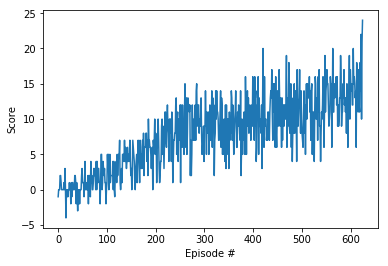

In [34]:
agent = Agent(state_space=state_size, action_space=action_size)
scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [15]:
agent.load_weights('checkpoint.pth')

Testing 
--------------

In [40]:

env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0  
while True:
    action = agent.act(state)     # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 14.0


In [ ]:
env.close()